<a href="https://colab.research.google.com/github/dophuong4024/mySite/blob/gh-pages/BabysitterAI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from torch.utils.data.sampler import SubsetRandomSampler
from torchvision.datasets import ImageFolder
from torchvision.utils import make_grid
from torch.autograd import Variable
from torchvision import transforms
from google.colab import drive

import matplotlib.pyplot as plt
import torch.nn.functional as F
import torch.optim as optim
import torch.nn as nn
import numpy as np
import shutil
import torch
import copy
import time
import os

%reload_ext autoreload
%autoreload 2
%matplotlib inline

drive.mount('/content/drive')

plt.rcParams['figure.figsize'] = (10.0, 8.0)
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

Mounted at /content/drive


In [ ]:
# Preprocessing images and load from train to val folder
source_dir = 'drive/My Drive/database/train'
dest_dir = 'drive/My Drive/database/val'
dirs = os.listdir(source_dir)
dirs.sort()

for dir in dirs:
    os.makedirs(dest_dir + "/" + dir, exist_ok=True)
    path_source = source_dir + "/" + dir
    path_dest = dest_dir + "/" + dir
    images = os.listdir(path_source)
    
    # was 120
    for i in range(20):
        shutil.copy(path_source + '/' + images[i], path_dest)

In [ ]:
# Load data
train_dir = 'drive/My Drive/database/train'
val_dir = 'drive/My Drive/database/val'
test_dir = 'drive/My Drive/database/test'
size = 224
batch_size = 32
num_workers = 8

data_transforms = {
    'train': transforms.Compose([
        transforms.CenterCrop(size),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ]),
    'val': transforms.Compose([
        transforms.CenterCrop(size),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ]),
    'test': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])
}


image_datasets = {
    'train': ImageFolder(train_dir, transform=data_transforms['train']),
    'val': ImageFolder(val_dir, transform=data_transforms['val']),
    'test': ImageFolder(test_dir, transform=data_transforms['test']),
}

data_loader = {
    x: torch.utils.data.DataLoader(image_datasets[x],
                                   batch_size=batch_size,
                                   shuffle=True,
                                   num_workers=num_workers) for x in ['train', 'val']
}

In [ ]:
# For imagenet we need to do some preprocessing for the labels
f = open("drive/My Drive/database/test.txt", "r")

labels_dict = {}
labels_list = []
class_count = 0
for line in f:
    split = line.split(' ', maxsplit=1)
    split[1] = split[1][:-1]
    label_id, label = split[0], split[1]
    labels_dict[label_id] = label
    labels_list.append(split[1])
    class_count = class_count + 1
   
print('Labels dict:-')
for idx, (key, value) in enumerate(labels_dict.items()):
    print(key, value)
    if (idx >= class_count):
        break
        
print('\nLabels list (just 0 indexed instead of file names)')
labels_list[:class_count]

Labels dict:-
no1 baby, safe
no2 baby, stand
no3 baby, climb
no4 baby, facedown

Labels list (just 0 indexed instead of file names)


['baby, safe', 'baby, stand', 'baby, climb', 'baby, facedown']

In [ ]:
# Our images are normalized so denormalize then and convert them to numpy
def imshow(img, title=None):
    img = img.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    img = std*img + mean
    # img = np.clip(img, 0, 1)
    plt.imshow(img)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)
images, labels = next(iter(data_loader['train']))
grid_img = make_grid(images[:50], nrow=4)
imshow(grid_img, title = [labels_list[x] for x in labels[:4]])

In [ ]:
#  Model Construction
class AlexNet(nn.Module):
    def __init__(self, num_classes=1000):
        super(AlexNet, self).__init__()
        self.conv_base = nn.Sequential(
            nn.Conv2d(3, 96, kernel_size=11, stride=4, padding=2, bias=False),
            nn.BatchNorm2d(96),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            
            nn.Conv2d(96, 256, kernel_size=5, stride=1, padding=2, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            
            nn.Conv2d(256, 384, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            
            nn.Conv2d(384, 384, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            
            nn.Conv2d(384, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
        )
        self.fc_base = nn.Sequential(
            nn.Dropout(),
            nn.Linear(256*6*6, 4096),
            nn.ReLU(inplace=True),
            
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            
            nn.Linear(4096, num_classes),
        )
        
    def forward(self, x):
        x = self.conv_base(x)
        x = x.view(x.size(0), 256*6*6)
        x = self.fc_base(x)
        return x
    
model = AlexNet()
model

AlexNet(
  (conv_base): Sequential(
    (0): Conv2d(3, 96, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2), bias=False)
    (1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(96, 256, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2), bias=False)
    (5): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU(inplace=True)
    (7): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(256, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(384, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1

In [ ]:
# Here we use indexing to index the layers, but in future cases we would name the layers
conv_list = [0, 4, 8, 10, 12]
fc_list = [1, 4, 6]
for i in conv_list:
    torch.nn.init.kaiming_normal_(model.conv_base[i].weight)
for i in fc_list:
    torch.nn.init.kaiming_normal_(model.fc_base[i].weight)

In [ ]:
# We train everything on GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

# Cross entropy loss takes the logits directly, so we don't need to apply softmax in our CNN
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=0.0005)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', verbose=True)

model = model.to(device)

cpu


In [ ]:
# A simple train loop.
def train(model, data_loader, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()
    
    train_batch_loss = []
    train_epoch_loss = []
    val_epoch_loss = []
    
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch+1, num_epochs))
        print('-'*15)
        
        # You perform validation test after every epoch
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
            else:
                model.eval()
                
            for idx, (inputs, labels) in enumerate(data_loader[phase]):
                inputs = inputs.to(device)
                labels = labels.to(device)
                
                # zero accumulated gradients
                optimizer.zero_grad()
                
                # During train phase we want to remember history for grads
                # and during val we do not want history of grads
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)
                    
                    _, preds = torch.max(outputs, 1)
                    
                    if idx%200 == 0:
                        train_batch_loss.append(loss.item())
                        print('Epoch {}: {}/{} step in progress'.format(epoch+1, idx, len(data_loader)))
                        
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                        
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
                
            epoch_loss = running_loss / len(data_loader[phase].dataset)
            epoch_acc = running_corrects.double() / len(data_loader[phase].dataset)
            
            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))
            
            if phase == 'val':
                val_epoch_loss.append((epoch_loss, epoch_acc))
                scheduler.step(loss.item())
            else:
                train_epoch_loss.append((epoch_loss, epoch_acc))
                
        print()
        
    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    
    return model

In [ ]:
inputs, labels = next(iter(data_loader['train']))
inputs = inputs.to(device)
labels = labels.to(device)

criterion_check1 = nn.CrossEntropyLoss()
optimizer_check1 = optim.SGD(model.parameters(), lr=0.001)

model.train()
for epoch in range(200):
    optimizer_check1.zero_grad()
    outputs = model(inputs)
    loss = criterion_check1(outputs, labels)
    _, preds = torch.max(outputs, 1)
    loss.backward()
    optimizer_check1.step()
    
    if epoch%10 == 0:
        print('Epoch {}: Loss = {} Accuracy = {}'.format(epoch+1, loss.item(), torch.sum(preds == labels)))

Epoch 1: Loss = 11.615190505981445 Accuracy = 0
Epoch 11: Loss = 1.6352359056472778 Accuracy = 19
Epoch 21: Loss = 1.105945110321045 Accuracy = 20
Epoch 31: Loss = 0.6078241467475891 Accuracy = 26
Epoch 41: Loss = 0.3999817669391632 Accuracy = 27
Epoch 51: Loss = 0.3298383951187134 Accuracy = 27
Epoch 61: Loss = 0.23648175597190857 Accuracy = 29
Epoch 71: Loss = 0.42738136649131775 Accuracy = 26
Epoch 81: Loss = 0.14954805374145508 Accuracy = 31
Epoch 91: Loss = 0.24277518689632416 Accuracy = 29
Epoch 101: Loss = 0.36550799012184143 Accuracy = 28
Epoch 111: Loss = 0.16569659113883972 Accuracy = 30
Epoch 121: Loss = 0.12556248903274536 Accuracy = 31
Epoch 131: Loss = 0.07476362586021423 Accuracy = 32
Epoch 141: Loss = 0.18166539072990417 Accuracy = 29
Epoch 151: Loss = 0.048166871070861816 Accuracy = 32
Epoch 161: Loss = 0.050625722855329514 Accuracy = 32
Epoch 171: Loss = 0.0502372570335865 Accuracy = 32
Epoch 181: Loss = 0.04132155701518059 Accuracy = 32
Epoch 191: Loss = 0.0428787805

In [ ]:
# Reinitialize weights
conv_list = [0, 4, 8, 10, 12]
fc_list = [1, 4, 6]
for i in conv_list:
    torch.nn.init.kaiming_normal_(model.conv_base[i].weight)
for i in fc_list:
    torch.nn.init.kaiming_normal_(model.fc_base[i].weight)

In [ ]:
# Carrying over the above case with regularization on
criterion_check1 = nn.CrossEntropyLoss()
optimizer_check1 = optim.SGD(model.parameters(), lr=0.001, weight_decay=0.05)

model.train()
for epoch in range(1):
    optimizer_check1.zero_grad()
    outputs = model(inputs)
    loss = criterion_check1(outputs, labels)
    _, preds = torch.max(outputs, 1)
    loss.backward()
    optimizer_check1.step()
    print('Epoch {}: Loss = {} Accuracy = {}'.format(epoch+1, loss.item(), torch.sum(preds == labels)))

Epoch 1: Loss = 10.411886215209961 Accuracy = 0


In [ ]:
class AlexNet_check(nn.Module):
    def __init__(self, num_classes=1000):
        super(AlexNet_check, self).__init__()
        self.conv_base = nn.Sequential(
            nn.Conv2d(3, 96, kernel_size=11, stride=4, padding=2),
#             nn.BatchNorm2d(96),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            
            nn.Conv2d(96, 256, kernel_size=5, stride=1, padding=2),
#             nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            
            nn.Conv2d(256, 384, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            
            nn.Conv2d(384, 384, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            
            nn.Conv2d(384, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
        )
        self.fc_base = nn.Sequential(
#             nn.Dropout(),
            nn.Linear(256*6*6, 4096),
            nn.ReLU(inplace=True),
            
#             nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            
            nn.Linear(4096, num_classes),
        )
        
    def forward(self, x):
        x = self.conv_base(x)
        x = x.view(x.size(0), 256*6*6)
        x = self.fc_base(x)
        return x
    
model_check2 = AlexNet_check()
model_check2 = model_check2.to(device)

# Initialize weights
conv_list = [0, 3, 6, 8, 10]
fc_list = [0, 2, 4]
for i in conv_list:
    torch.nn.init.kaiming_normal_(model_check2.conv_base[i].weight)
for i in fc_list:
    torch.nn.init.kaiming_normal_(model_check2.fc_base[i].weight)
    
criterion_check = nn.CrossEntropyLoss()
optimizer_check = optim.Adam(model_check2.parameters(), lr=0.001)

In [ ]:
model_check2.train()
for epoch in range(1):
    optimizer_check.zero_grad()
    outputs = model(inputs)
    loss = criterion_check(outputs, labels)
    _, preds = torch.max(outputs, 1)
    loss.backward()
    optimizer_check.step()
    print('Epoch {}: Loss = {} Accuracy = {}'.format(epoch+1, loss.item(), torch.sum(preds == labels)))

Epoch 1: Loss = 4.771462440490723 Accuracy = 23


climb
facedown
safe
stand


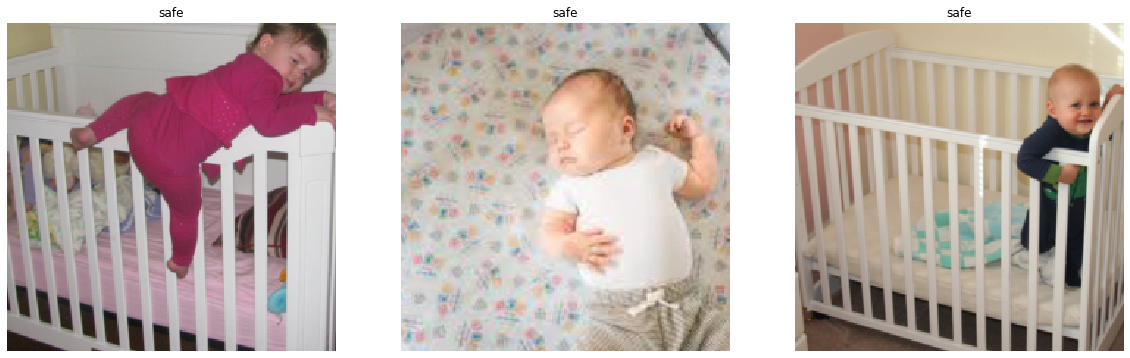

In [ ]:
# this part is for predicting testing images
def get_random_images(num):
    data = image_datasets['test']
    classes = data.classes
    indices = list(range(len(data)))
    np.random.shuffle(indices)

    idx = indices[:num]
    sampler = SubsetRandomSampler(idx)
    loader = torch.utils.data.DataLoader(data, 
                   sampler=sampler, batch_size=num)
    dataiter = iter(loader)
    images, labels = dataiter.next()
    return images, labels

def predict_image(image):
    image_tensor = data_transforms['test'](image).float()
    image_tensor = image_tensor.unsqueeze_(0)
    input = Variable(image_tensor)
    input = input.to(device)
    output = model(input)
    index = output.data.cpu().numpy().argmax()
    return index

to_pil = transforms.ToPILImage()
images, labels = get_random_images(3)
fig=plt.figure(figsize=(20,20))
fig.set_facecolor("white")
class_names = image_datasets['train'].classes

for i in range(len(images)):
  image = to_pil(images[i])
  index = predict_image(image)
  sub = fig.add_subplot(1, len(images), i+1)

  img = images[i].numpy().transpose((1, 2, 0))
  mean = np.array([0.485, 0.456, 0.406])
  std = np.array([0.229, 0.224, 0.225])
  img = std*img + mean
  img = np.clip(img, 0, 1)
  sub.set_title(str(class_names[index]))
  plt.imshow(img)
  plt.axis('off')
  plt.imshow(img)

print(class_names[0])
print(class_names[1])
print(class_names[2])
print(class_names[3])

plt.show()